## ChatGPT Labelling

#### Glossary

1. ChatGPT API Connection
2. Verification of the labelling on text already labelled by us
3. Labelling by ChatGPT

In [858]:
#!pip install openai
#!pip install langchain
#!pip install python-Levenshtein
#!pip install fuzzywuzzy
#!pip install sentence_transformers

In [859]:
import re
import ast
import pickle
import Levenshtein
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from openai import OpenAI
from jinja2 import Template

tqdm.pandas()

#ECB Color
color = (17/255, 49/255, 147/255)

# TODO: Fuzz matching for the entities: from fuzzywuzzy import fuzz

In [860]:
# Set your OpenAI API key
api_key = open("C:\\Users\\School\\Desktop\\GPT_KEY.txt", "r").read()

In [861]:
# Functions:
# Function to count the frequency of words from the list in a sentence
def count_frequency(answer, words_to_match):
    if pd.isna(answer):
        return 0
    sentence_lower = answer.lower()
    return sum(sentence_lower.count(word) for word in words_to_match)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_end_answer(text):
    text = text.replace(r'[end_answer]', '')
    return text

def remove_special_characters_keep_point(text):
    # Define the regex pattern to match special characters except "."
    pattern = r"[^\w\s\.\']"
    # Replace special characters with an empty string
    text = re.sub(pattern, '', text)
    # Replace consecutive dots with just one dot
    text = re.sub(r'\.{2,}', '.', text)
    return text

# Function to extract sentences containing specific words
def extract_sentences(text, words_to_match):
    # Compile regex pattern to split text into sentences
    sentence_pattern = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s')
    
    sentences = sentence_pattern.split(text)
    return [sentence for sentence in sentences if any(word in sentence for word in words_to_match)]

def remove_unnecessary_spaces(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_starting_month(text):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    pattern = r'^(' + '|'.join(months) + r')\s'
    text = re.sub(pattern, '', text)
    return text

def remove_special_characters(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return cleaned_text

# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [862]:
# Import dataset containing the interveiw data
df = pd.read_csv('Final_Working_Data_with_GPTS.csv')

In [863]:
# drop 'Sentence_GPT', 'Category_GPT'
df.drop(['Sentence_GPT', 'Category_GPT'], axis=1, inplace=True)

### Prepare the data for the labeling

In [864]:
def preprocess_text(df,words_to_match):
        text_preproc = (
                df.Answers
                .astype(str)
                .progress_apply(lambda row: remove_end_answer(row))
                .progress_apply(lambda row: remove_special_characters_keep_point(row))
                .progress_apply(lambda row: remove_unnecessary_spaces(row))
                .progress_apply(lambda row: remove_starting_month(row))
                .progress_apply(lambda row: extract_sentences(row,words_to_match)))

        df["Sentences"]=text_preproc

        return df

df = preprocess_text(df, words_to_match=words_to_match)

100%|██████████| 519/519 [00:00<00:00, 1159.30it/s]


In [865]:
df["Frequency"] = df["Answers"].apply(count_frequency, words_to_match=words_to_match)
df['Sentences_len'] = df['Sentences'].apply(len)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


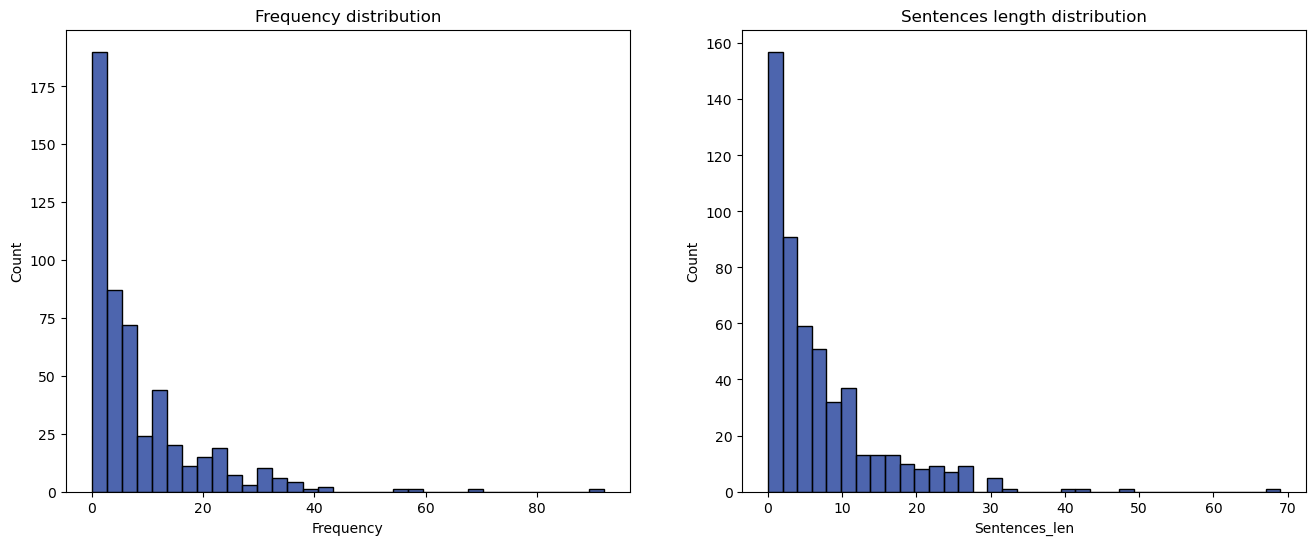

In [866]:
# Plot the distribution of Frequency and Sentences_len
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df["Frequency"], ax=ax[0], color=color)
ax[0].set_title("Frequency distribution")
sns.histplot(df["Sentences_len"], ax=ax[1], color=color)
ax[1].set_title("Sentences length distribution")
plt.show()

### Keep only labeled data, to test GPT perfromance

In [867]:
# Dataframe with the labeled Metaphors
df_labels = df[df['Metaphors'].notnull()].copy()
print("Shape of the dataset with labeled Metaphors: ", df_labels.shape)

Shape of the dataset with labeled Metaphors:  (68, 24)


In [868]:
# This cell could be unnecessay in later versions

# lambda function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if x != '[\'None\']' else []
df_labels.loc[:, 'Metaphors Sentence'] = df_labels['Metaphors Sentence'].apply(parse_list)

# lambda function to count the elements in each list
df_labels.loc[:, 'Metaphors_len'] = df_labels['Metaphors Sentence'].apply(len)

In [869]:
# Print total number of Metaphors
print("Total number of Metaphors (Label): ", df_labels['Metaphors_len'].sum())
print("Total number of Sentences (with words_to_match): ", df_labels['Sentences'].apply(len).sum())
print("Average number of Metaphors per Interview: ", df_labels['Metaphors_len'].mean())
print("Ratio of Metaphors to Sentences: ", df_labels['Metaphors_len'].sum() / df_labels['Sentences'].apply(len).sum())

Total number of Metaphors (Label):  493
Total number of Sentences (with words_to_match):  574
Average number of Metaphors per Interview:  7.25
Ratio of Metaphors to Sentences:  0.8588850174216028


In [870]:
# Some of the labeled Metaphors have the Starting date of the interview, we need to remove it as it was removed from the Sentences
df_labels['Metaphors Sentence'] = df_labels['Metaphors Sentence'].apply(lambda x: [remove_starting_month(sentence) for sentence in x])

# Some of the labeled Metaphors have a "low;" in the string resulting from an error, we need to remove it as it not present in the Sentences
df_labels['Metaphors Sentence'] = df_labels['Metaphors Sentence'].apply(lambda x: [sentence.replace("low;", " ") for sentence in x])

In [871]:
df_labels.head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,list_regex_reduced,list_regex_len,list_regex_reduced_len,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Metaphors_len
47,47,2009-09-12,"Interview with the ""Junge Zeitung“ of the Fran...",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,NaN,"Mr. President, as „Mr. Euro“: How many Euros d...","['fear deflation', 'inflation below', 'preserv...","[Or does the ECB fear deflation, Our definitio...",...,"['at the moment there be no inflation ', 'can ...",5,5,11198,[],0,"[At the moment there is no inflation., Can you...",7,5,5
65,65,2010-04-24,Interview with Expresso,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,Are we really leaving the crisis behind or are...,As regards the conjuncture in the real economy...,['None'],[],...,[],0,0,12101,[],0,[],0,0,0
73,73,2011-10-18,Interview with Frankfurter Allgemeine Zeitung,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,"Mr Trichet, do you believe in destiny?[end_que...",I have used that term on a few occasions – inc...,"['experience of hyperinflationr', 'experienced...","[As regards inflation, I understand the deep-s...",...,"['average annual inflation have at ', 'as rega...",6,6,12782,"[('annual', 'inflation')]",1,[Average annual inflation has at 2.0 over the ...,9,6,4
79,79,2011-09-20,Interview with Expansión,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,1. At the last meeting you said that the risks...,At the last meeting of the Governing Council w...,"['upside risks to inflation', 'materialisation...","[On the other hand, in July there were upside ...",...,['on the other hand in July there be upside ri...,2,2,7295,[],0,[On the other hand in July there were upside r...,3,2,3
85,85,2011-06-16,Interview with The Times,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,The Times: There are two camps: one that empha...,Jean-Claude Trichet: All advanced economies ar...,"['anchor very solidly inflation', 'materialisa...",[What I would say is that in our case it is ve...,...,['annual average inflation over the past year ...,6,6,10455,"[('annual', 'inflation')]",1,[Annual average inflation over the past 12 yea...,12,6,5


In [872]:
from fuzzywuzzy import fuzz

def compare_list(list1, list2, threshold=0.7):
    # Preprocess both lists
    list1 = preprocess_list(list1)
    list2 = preprocess_list(list2)
    
    # Check if elements from list1 are similar to elements in list2
    matches = []
    for sentence1 in list1:
        for sentence2 in list2:
            distance = fuzz.ratio(sentence1, sentence2) / 100 
            if distance >= threshold or words_are_subset(sentence1, sentence2):
                match_found = True
                matches.append(match_found)
                break
    return matches

def add_match_column(df, threshold=0.7):
    comparison_results = []

    for index, row in df.iterrows():
        if isinstance(row['Sentences'], list) and isinstance(row['Metaphors Sentence'], list):
            result = compare_list(row['Sentences'], row['Metaphors Sentence'], threshold)
        else:
            result = []
        comparison_results.append(result)
    
    df['Matched_Labeled'] = comparison_results
    df['Matched_Labeled_len'] = df['Matched_Labeled'].apply(len)
    return df

def remove_special_characters_except_colon(text):
    # Define a regex pattern to match all special characters except colon
    pattern = r'[^A-Za-z0-9\s:]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

def parse_output(output):
    sentences = []
    categories = []

    # Clean the output text
    cleaned_output = remove_special_characters_except_colon(output)

    # Split by "Sentence:"
    split_output = cleaned_output.split('Sentence:')

    for part in split_output[1:]:  # Skip the first split part which is before the first 'Sentence:'
        if 'Category:' in part:
            # Extract sentence and category
            sentence, category = part.split('Category:')
            sentences.append(sentence.strip().lower())
            category = re.split(r'\s+', category.strip().lower())[0]  # Get the first word for category
            categories.append(category.strip().lower())

    return sentences, categories

def preprocess_sentence(sentence):
    # Remove special characters except for content inside brackets and parentheses
    cleaned_sentence = re.sub(r'[^A-Za-z\s]', '', sentence)
    cleaned_sentence = re.sub(r'\s+', '', cleaned_sentence)  # Remove extra spaces
    return cleaned_sentence.strip().lower()

def is_subsequence(words1, words2):
    it = iter(words2)
    return all(word in it for word in words1)

def words_are_subset(sentence1, sentence2):
    words1 = sentence1.split()
    words2 = sentence2.split()
    return is_subsequence(words1, words2) or is_subsequence(words2, words1)

def add_comparison_column(df, threshold=30, name='GPT_1'): 
    comparison_results = []

    for index, row in df.iterrows():
        if isinstance(row[f'Sentence_{name}'], list) and isinstance(row['Metaphors Sentence'], list):
            result = compare_sentence_lists(row[f'Sentence_{name}'], row['Metaphors Sentence'], threshold)
        else:
            result = []
        comparison_results.append(result)

    df[f'Comparison_Result_{name}'] = comparison_results
    return df

def add_columns_to_dataframe(df, output, name='GPT'):
    # Initialize lists for the new columns with None or empty lists
    df[f'Sentence_{name}'] = [None] * len(df)
    df[f'Category_{name}'] = [None] * len(df)

    output_index = 0

    for index, row in df.iterrows():
        if len(row['Sentences']) > 0 and output_index < len(output):
            sentences, categories = parse_output(output[output_index])
            df.at[index, f'Sentence_{name}'] = sentences
            df.at[index, f'Category_{name}'] = categories
            output_index += 1
        else:
            df.at[index, f'Sentence_{name}'] = []
            df.at[index, f'Category_{name}'] = []

    return df

def preprocess_list(sentence_list):
    return [preprocess_sentence(sentence) for sentence in sentence_list]


def add_comparison_column_GPT(df, threshold=30):
    comparison_results = []

    for index, row in df.iterrows():
        if isinstance(row['Sentence_GPT'], list) and isinstance(row['Sentences'], list):
            result = compare_sentence_lists(row['Sentence_GPT'], row['Sentences'], threshold)
        else:
            result = []
        comparison_results.append(result)

    df['Matched_Metaphors'] = comparison_results
    return df

def compare_sentence_lists(list1, list2, threshold=20):
    # Preprocess both lists
    list1 = preprocess_list(list1)
    list2 = preprocess_list(list2)
    
    # Check if elements from list1 are similar to elements in list2
    matches = []
    for sentence1 in list1:
        match_found = False
        for sentence2 in list2:
            distance = Levenshtein.distance(sentence1, sentence2)
            if distance <= threshold or words_are_subset(sentence1, sentence2):
                match_found = True
                break
        matches.append(match_found)
    return matches


def add_comparison_column_Fuzzy(df, threshold=0.9, name='GPT_1'):
    comparison_results = []

    for index, row in df.iterrows():
        if isinstance(row[f'Sentence_{name}'], list) and isinstance(row['Metaphors Sentence'], list):
            result = compare_sentence_lists_Fuzzy(row[f'Sentence_{name}'], row['Metaphors Sentence'], threshold)
        else:
            result = []
        comparison_results.append(result)

    df[f'Matched_Metaphors_Fuzzy_{name}'] = comparison_results
    return df

def compare_sentence_lists_Fuzzy(list1, list2, threshold=0.9):
    # Preprocess both lists
    list1 = preprocess_list(list1)
    list2 = preprocess_list(list2)
    
    # Check if elements from list1 are similar to elements in list2
    matches = []
    for sentence1 in list1:
        match_found = False
        for sentence2 in list2:
            distance = fuzz.ratio(sentence1, sentence2) / 100 
            if distance >= threshold or words_are_subset(sentence1, sentence2):
                match_found = True
                break
        matches.append(match_found)
    return matches


In [873]:
# Sanity check: Match 'Metaphors Sentence' with 'Sentences' to see if they are present
df_temp = add_match_column(df_labels.copy(), threshold=0.5)

# Compare the 'Matched_Labeled_len' with 'Metaphors_len' to see if all the Metaphors are matched
df_temp['Matched_Labeled_len'].sum(), df_temp['Metaphors_len'].sum()

(472, 493)

Some of the labeled sentences do not match with the 'Sentences' extracted from the interviews. The Fuzzy threshold had to be set to 0.5 to match the most possible Metaphors. This might be due to Human error while labeling or the preprocessing step removing special characters such as "-" that might change the meaning of a word.

### 1. ChatGPT API Connection


In [890]:
initial_prompt = open("GPT_Prompts/Prompt_3.txt", "r").read()

following_prompts = """Detect and extract the conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation in the following sentences:
{{list_sentences}}

Return the metaphors in the format:
Sentence: [Sentence text] Category: [Category]

Where, Category is one of the following:
Fire, Liquids, Plant, Animal, Disease, Warfare, Sports, Machine, Orientation, Other

The output has to be in the right format. The categories are predefined and you have to choose the right category based on the metaphor used in the sentence.
"""

following_prompts = Template(following_prompts)

In [891]:
df_labels["Sentences"].iloc[3]

['On the other hand in July there were upside risks to inflation but now they are balanced.',
 'This is a major asset for Europe it protects us from the materialisation of the risk of inflation as well as the materialisation of the risk of deflation.']

In [892]:
print(following_prompts.render(list_sentences=df["Sentences"].iloc[2]))

# Limit size of df to 10
#df_labels = df_labels.iloc[:10]

sentences_list = []

for index, row in df.iterrows():
    sentences = row["Sentences"]
    if len(sentences) > 0:
        sentences_list.append(sentences)

print(len(sentences_list))

Detect and extract the conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation in the following sentences:
['If longterm interest rates remain at a low level as a result of favourable inflation expectations influenced by a credible monetary policy oriented towards price stability and as a consequence of the impact of other factors then the effect on economic activity of a rise in shortterm interest rates is going to be more muted.', 'Public perceptions and expectations of future inflation should be favourably influenced by a change in the monetary policy stance that aims at preserving price stability.', 'It a higher level of interest rates could foster expectations of lower inflation and higher real disposable incomes and increase confidence particularly in countries where public perceptions of current inflation are less favourable than actual inflation and financial markets inflation expectations.', 'It was necessary in ord

In [893]:
all_prompts = [initial_prompt] + [following_prompts.render(list_sentences=sentences) for sentences in sentences_list]
all_prompts[:3]

['Title: Conceptual Metaphor Detection\n\nDescription: Detect and extract conceptual Metaphors in a set of sentences.\n\nTask: Given a set of sentences, you are required to identify and extract conceptual metaphors present.  \nOnly consider conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation.\nAfter identifying the metaphors, return the sentences that contain the metaphors and label it in the format:\n\nSentence: [Sentence text] Category: [Category]\n\nWhere Category is one of the following 10 options:\nFire, Liquids, Plant, Animal, Disease, Warfare, Sports, Machine, Orientation, Other\n\nDefinition: Conceptual metaphors refer to linguistic expressions that metaphorically represent abstract concepts in terms of more concrete concepts.\n\nAdditional Instructions:\n- If one sentence contains multiple metaphors, return the sentence multiple times with each metaphor labeled separately.\n\nExample Input:\n["China worries that

In [894]:
all_prompts = [[{"role": "system", "content": prompt}] for prompt in all_prompts]
#all_prompts

In [898]:
"""client = OpenAI(api_key=api_key)

# model: "gpt-3.5-turbo", "gpt-4o"
# temperature: Controls the creativity of the responses. Lower values make the output more focused and deterministic, while higher values make it more random
# We want GPT to be more deterministic and focused, and return the metaphors in the right format - Default value: 0
gpt_answer = [client.chat.completions.create(messages=msg, model='gpt-4o', temperature=0).choices[0].message.content for msg in all_prompts]""""""

In [899]:
"""gpt_answer
print(len(gpt_answer))"""

406


In [900]:
"""# Save the GPT-4 output to a pickle file
with open('gpt_answer_all_3.pkl', 'wb') as f:
    pickle.dump(gpt_answer, f)"""

### Investigate the 3 different outputs:

As 3 different prompts were tested and saved, now we will analyse the outputs and keep the metaphors appearing at least twice in a final 'robust' dataset.

In [819]:
# Fale-Negative score for each prompt.
# AUC Curve for each prompt.

# False-Negative for majority vote
# AUC Curve for majority vote

In [820]:
# Load the GPT-4 output from the pickle file
with open('gpt_answer_1.pkl', 'rb') as f:
    gpt_answer_1 = pickle.load(f)

with open('gpt_answer_2.pkl', 'rb') as f:
    gpt_answer_2 = pickle.load(f)

with open('gpt_answer_3.pkl', 'rb') as f:
    gpt_answer_3 = pickle.load(f)

# Drop the first element which is the initial prompt
gpt_answer_1 = gpt_answer_1[1:]
gpt_answer_2 = gpt_answer_2[1:]
gpt_answer_3 = gpt_answer_3[1:]

gpt_names = ["GPT_1", "GPT_2", "GPT_3", "GPT_Majority"]

print("The length of the GPT-4 output for the first prompt: ", len(gpt_answer_1))
print("The length of the GPT-4 output for the second prompt: ", len(gpt_answer_2))
print("The length of the GPT-4 output for the third prompt: ", len(gpt_answer_3))

The length of the GPT-4 output for the first prompt:  58
The length of the GPT-4 output for the second prompt:  58
The length of the GPT-4 output for the third prompt:  58


In [821]:
print("Shape of the dataset before adding GPT-4 output: ", df_labels.shape)

# Drop the rows where the Sentences are empty
#df_labels = df_labels[df_labels['Sentences'].apply(len) > 0]

print("Shape of the dataset after dropping empty Sentences: ", df_labels.shape)

for gpt_name, gpt_answer in zip(gpt_names, [gpt_answer_1, gpt_answer_2, gpt_answer_3]):
    df_labels = add_columns_to_dataframe(df_labels, gpt_answer, name=gpt_name)

print("Shape of the dataset after adding GPT-4 output: ", df_labels.shape)

df_labels.head()

Shape of the dataset before adding GPT-4 output:  (68, 25)
Shape of the dataset after dropping empty Sentences:  (68, 25)
Shape of the dataset after adding GPT-4 output:  (68, 31)


,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,Sentences,Frequency,Sentences_len,Metaphors_len,Sentence_GPT_1,Category_GPT_1,Sentence_GPT_2,Category_GPT_2,Sentence_GPT_3,Category_GPT_3
47,47,2009-09-12,"Interview with the ""Junge Zeitung“ of the Fran...",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,NaN,"Mr. President, as „Mr. Euro“: How many Euros d...","['fear deflation', 'inflation below', 'preserv...","[Or does the ECB fear deflation, Our definitio...",...,"[At the moment there is no inflation., Can you...",7,5,5,[can you say that you accomplished your missio...,"[warfare, warfare, sports]",[since the inception of the single currency we...,"[warfare, sports]",[can you say that you accomplished your missio...,"[warfare, warfare, sports]"
65,65,2010-04-24,Interview with Expresso,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,Are we really leaving the crisis behind or are...,As regards the conjuncture in the real economy...,['None'],[],...,[],0,0,0,[],[],[],[],[],[]
73,73,2011-10-18,Interview with Frankfurter Allgemeine Zeitung,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,"Mr Trichet, do you believe in destiny?[end_que...",I have used that term on a few occasions – inc...,"['experience of hyperinflationr', 'experienced...","[As regards inflation, I understand the deep-s...",...,[Average annual inflation has at 2.0 over the ...,9,6,4,[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]"
79,79,2011-09-20,Interview with Expansión,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,1. At the last meeting you said that the risks...,At the last meeting of the Governing Council w...,"['upside risks to inflation', 'materialisation...","[On the other hand, in July there were upside ...",...,[On the other hand in July there were upside r...,3,2,3,[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]"
85,85,2011-06-16,Interview with The Times,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,The Times: There are two camps: one that empha...,Jean-Claude Trichet: All advanced economies ar...,"['anchor very solidly inflation', 'materialisa...",[What I would say is that in our case it is ve...,...,[Annual average inflation over the past 12 yea...,12,6,5,[we consider that such anchoring has been a ve...,"[warfare, sports, sports, warfare]",[we consider that such anchoring has been a ve...,"[warfare, sports, sports, orientation]",[what i would say is that in our case it is ve...,"[orientation, orientation, sports, sports, ori..."


In [822]:
# Sanity check:
print("Total number of Metaphors labeled: ", df_labels['Metaphors_len'].sum())
print("Total number of Sentences (with words_to_match): ", df_labels['Sentences'].apply(len).sum())
print("")
print("Total number of sentences in the 'Sentence_GPT_1' column: ", df_labels['Sentence_GPT_1'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT_2' column: ", df_labels['Sentence_GPT_2'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT_3' column: ", df_labels['Sentence_GPT_3'].apply(len).sum())
print("")
print("Ratio of GPT (Prompt 1) Metaphors to Sentences: ", df_labels['Sentence_GPT_1'].apply(len).sum() / df_labels['Sentences'].apply(len).sum())
print("Ratio of GPT (Prompt 2) Metaphors to Sentences: ", df_labels['Sentence_GPT_2'].apply(len).sum() / df_labels['Sentences'].apply(len).sum())
print("Ratio of GPT (Prompt 3) Metaphors to Sentences: ", df_labels['Sentence_GPT_3'].apply(len).sum() / df_labels['Sentences'].apply(len).sum())

Total number of Metaphors labeled:  493
Total number of Sentences (with words_to_match):  574

Total number of sentences in the 'Sentence_GPT_1' column:  497
Total number of sentences in the 'Sentence_GPT_2' column:  497
Total number of sentences in the 'Sentence_GPT_3' column:  505

Ratio of GPT (Prompt 1) Metaphors to Sentences:  0.8658536585365854
Ratio of GPT (Prompt 2) Metaphors to Sentences:  0.8658536585365854
Ratio of GPT (Prompt 3) Metaphors to Sentences:  0.8797909407665505


### Majority voting:

Keep only the Metaphors that appear in at least two of the 3 outputs given by 3 different prompts.

In [823]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

def majority_voting_with_category(df):
    # Function to determine majority voting for a single row
    def get_majority_vote_with_category(row):
        sentences = row['Sentence_GPT_1'] + row['Sentence_GPT_2'] + row['Sentence_GPT_3']
        categories = row['Category_GPT_1'] + row['Category_GPT_2'] + row['Category_GPT_3']
        
        vote_count = pd.Series(sentences).value_counts()
        majority_sentences = vote_count[vote_count >= 2].index.tolist()
        
        majority_categories = []
        for sentence in majority_sentences:
            for i in range(3):
                if sentence in row[f'Sentence_GPT_{i+1}']:
                    idx = row[f'Sentence_GPT_{i+1}'].index(sentence)
                    majority_categories.append(row[f'Category_GPT_{i+1}'][idx])
                    break
        
        return majority_sentences, majority_categories
    
    # Apply the function to each row to get the majority vote and corresponding categories
    df[['Sentence_GPT_Majority', 'GPT_Majority_Category']] = df.apply(lambda row: pd.Series(get_majority_vote_with_category(row)), axis=1)
    
    return df

def calculate_metrics(df_labels, gpt_name, Fuzzy=False,true_metaphor_count=493):
    # Flatten the lists of true metaphors and predicted matches
    total_metaphors = df_labels[f'Sentence_{gpt_name}'].apply(len).sum()
    if Fuzzy:
        true_positive = df_labels[f'Matched_Metaphors_Fuzzy_{gpt_name}'].apply(sum).sum()
        flattened_results = [item for sublist in df_labels[f'Matched_Metaphors_Fuzzy_{gpt_name}'] for item in sublist]
        print("Length of flattened results: ", len(flattened_results))
        print(flattened_results[:5])
    else:
        true_positive = df_labels[f'Comparison_Result_{gpt_name}'].apply(sum).sum()
        flattened_results = [item for sublist in df_labels[f'Comparison_Result_{gpt_name}'] for item in sublist]
        print("Length of flattened results: ", len(flattened_results))
        print(flattened_results[:5])

    # Calculate false positives and false negatives
    false_positive = total_metaphors - true_positive
    false_negative = true_metaphor_count - true_positive

    # Print the statistics
    """print(f"Total number of Metaphors (prompt {gpt_name}): {total_metaphors}")
    print(f"Total number of True values for (prompt {gpt_name}): {true_positive}")
    print(f"False Positives: {false_positive}")
    print(f"False Negatives: {false_negative}")"""

    # Calculate precision, recall, and F1 score
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = true_positive / total_metaphors
    
    print(f"Accuracy (prompt {gpt_name}): {accuracy}")
    print(f"Precision (prompt {gpt_name}): {precision}")
    print(f"Recall (prompt {gpt_name}): {recall}")
    print(f"F1 Score (prompt {gpt_name}): {f1}")
    print("")
    return flattened_results

In [824]:
df_labels = majority_voting_with_category(df_labels)
print("Ratio of GPT (Prompt 3) Metaphors to Sentences: ", df_labels['Sentence_GPT_Majority'].apply(len).sum() / df_labels['Sentences'].apply(len).sum())

Ratio of GPT (Prompt 3) Metaphors to Sentences:  0.8815331010452961


The ratio of metaphor per sentence containing the word 'inflation' went up after majority voting, hence resulting in more robust results for the rest of the analysis.

### Preprocessing the labeled sentences and GPT answers to perform analysis:

In [825]:
for gpt_name in gpt_names:
    df_labels = add_comparison_column(df_labels, threshold=30, name=gpt_name)

In [826]:
for gpt_name in gpt_names:
    print(f"Total number of Metaphors (prompt {gpt_name}): ", df_labels[f'Sentence_{gpt_name}'].apply(len).sum())
    print(f"Total number of True values for (prompt {gpt_name}): ", df_labels[f'Comparison_Result_{gpt_name}'].apply(sum).sum())
    print(f"Ratio of Metaphors correctly identified (vs labeled data) (prompt {gpt_name}): ", df_labels[f'Comparison_Result_{gpt_name}'].apply(sum).sum() / df_labels[f'Comparison_Result_{gpt_name}'].apply(len).sum())
    print("")

Total number of Metaphors (prompt GPT_1):  497
Total number of True values for (prompt GPT_1):  383
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_1):  0.7706237424547284

Total number of Metaphors (prompt GPT_2):  497
Total number of True values for (prompt GPT_2):  389
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_2):  0.7826961770623743

Total number of Metaphors (prompt GPT_3):  505
Total number of True values for (prompt GPT_3):  386
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_3):  0.7643564356435644

Total number of Metaphors (prompt GPT_Majority):  506
Total number of True values for (prompt GPT_Majority):  389
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_Majority):  0.7687747035573123



In [827]:
df_labels.head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,Sentence_GPT_2,Category_GPT_2,Sentence_GPT_3,Category_GPT_3,Sentence_GPT_Majority,GPT_Majority_Category,Comparison_Result_GPT_1,Comparison_Result_GPT_2,Comparison_Result_GPT_3,Comparison_Result_GPT_Majority
47,47,2009-09-12,"Interview with the ""Junge Zeitung“ of the Fran...",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,NaN,"Mr. President, as „Mr. Euro“: How many Euros d...","['fear deflation', 'inflation below', 'preserv...","[Or does the ECB fear deflation, Our definitio...",...,[since the inception of the single currency we...,"[warfare, sports]",[can you say that you accomplished your missio...,"[warfare, warfare, sports]",[since the inception of the single currency we...,"[warfare, sports, warfare]","[False, True, True]","[True, True]","[False, True, True]","[True, True, False]"
65,65,2010-04-24,Interview with Expresso,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,Are we really leaving the crisis behind or are...,As regards the conjuncture in the real economy...,['None'],[],...,[],[],[],[],[],[],[],[],[],[]
73,73,2011-10-18,Interview with Frankfurter Allgemeine Zeitung,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,"Mr Trichet, do you believe in destiny?[end_que...",I have used that term on a few occasions – inc...,"['experience of hyperinflationr', 'experienced...","[As regards inflation, I understand the deep-s...",...,[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]","[True, True]","[True, True]","[True, True]","[True, True]"
79,79,2011-09-20,Interview with Expansión,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,1. At the last meeting you said that the risks...,At the last meeting of the Governing Council w...,"['upside risks to inflation', 'materialisation...","[On the other hand, in July there were upside ...",...,[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]","[True, True]","[True, True]","[True, True]","[True, True]"
85,85,2011-06-16,Interview with The Times,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,The Times: There are two camps: one that empha...,Jean-Claude Trichet: All advanced economies ar...,"['anchor very solidly inflation', 'materialisa...",[What I would say is that in our case it is ve...,...,[we consider that such anchoring has been a ve...,"[warfare, sports, sports, orientation]",[what i would say is that in our case it is ve...,"[orientation, orientation, sports, sports, ori...",[we consider that such anchoring has been a ve...,"[warfare, sports, sports, warfare]","[True, True, True, False]","[True, True, True, False]","[True, True, True, True, False]","[True, True, True, False]"


In [828]:
# Print the sum of the list in Matched_Metaphors_Fuzzy_GPT_3
print("Total number of True values for (prompt GPT_3): ", df_labels['Comparison_Result_GPT_3'].apply(sum).sum())
# Print the sum of the length of the list in Comparison_Result_GPT_3
print("Total number of Metaphors (prompt GPT_3): ", df_labels['Comparison_Result_GPT_3'].apply(len).sum())

Total number of True values for (prompt GPT_3):  386
Total number of Metaphors (prompt GPT_3):  505


In [829]:
df_labels

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,Sentence_GPT_2,Category_GPT_2,Sentence_GPT_3,Category_GPT_3,Sentence_GPT_Majority,GPT_Majority_Category,Comparison_Result_GPT_1,Comparison_Result_GPT_2,Comparison_Result_GPT_3,Comparison_Result_GPT_Majority
47,47,2009-09-12,"Interview with the ""Junge Zeitung“ of the Fran...",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,NaN,"Mr. President, as „Mr. Euro“: How many Euros d...","['fear deflation', 'inflation below', 'preserv...","[Or does the ECB fear deflation, Our definitio...",...,[since the inception of the single currency we...,"[warfare, sports]",[can you say that you accomplished your missio...,"[warfare, warfare, sports]",[since the inception of the single currency we...,"[warfare, sports, warfare]","[False, True, True]","[True, True]","[False, True, True]","[True, True, False]"
65,65,2010-04-24,Interview with Expresso,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,Are we really leaving the crisis behind or are...,As regards the conjuncture in the real economy...,['None'],[],...,[],[],[],[],[],[],[],[],[],[]
73,73,2011-10-18,Interview with Frankfurter Allgemeine Zeitung,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,"Mr Trichet, do you believe in destiny?[end_que...",I have used that term on a few occasions – inc...,"['experience of hyperinflationr', 'experienced...","[As regards inflation, I understand the deep-s...",...,[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]","[True, True]","[True, True]","[True, True]","[True, True]"
79,79,2011-09-20,Interview with Expansión,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,1. At the last meeting you said that the risks...,At the last meeting of the Governing Council w...,"['upside risks to inflation', 'materialisation...","[On the other hand, in July there were upside ...",...,[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]","[True, True]","[True, True]","[True, True]","[True, True]"
85,85,2011-06-16,Interview with The Times,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,The Times: There are two camps: one that empha...,Jean-Claude Trichet: All advanced economies ar...,"['anchor very solidly inflation', 'materialisa...",[What I would say is that in our case it is ve...,...,[we consider that such anchoring has been a ve...,"[warfare, sports, sports, orientation]",[what i would say is that in our case it is ve...,"[orientation, orientation, sports, sports, ori...",[we consider that such anchoring has been a ve...,"[warfare, sports, sports, warfare]","[True, True, True, False]","[True, True, True, False]","[True, True, True, True, False]","[True, True, True, False]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,490,2023-05-24,Interview with Les Echos,Fabio Panetta,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Fabio Panetta, Member of the Ex...",As the ECB celebrates its 25th anniversary tod...,24 May 2023[end_answer] We are studying the de...,['None'],[],...,[],[],[],[],[],[],[],[],[],[]
491,491,2023-05-14,Interview with Il Sole 24 Ore,Luis de Guindos,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Luis de Guindos, Vice-President...","With seven hikes in one year, the ECB has rais...",14 May 2023[end_answer] Our mandate is price s...,"['high inflation', 'high inflation', 'inflatio...",[Our mandate is price stability and tightened ...,.

In [830]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def extract_sentences(df):
    all_sentences = []
    
    for index, row in df.iterrows():
        if isinstance(row['Sentences'], list):
            all_sentences.extend(row['Sentences'])
    
    return all_sentences

def extract_metaphors(df, name=None):
    all_metaphors = []
    
    if name is None:
        for index, row in df.iterrows():
            if isinstance(row['Metaphors Sentence'], list):
                all_metaphors.extend(row['Metaphors Sentence'])
    else:
        for index, row in df.iterrows():
            if isinstance(row[f'Sentence_{name}'], list):
                all_metaphors.extend(row[f'Sentence_{name}'])
    
    return all_metaphors

def compare_sentence_fuzzy(sentence1, sentence2, threshold=0.7):
    distance = fuzz.ratio(sentence1, sentence2) / 100
    if distance >= threshold or words_are_subset(sentence1, sentence2):
        return True
    return False

def metrics_dataframe(list_sentences, list_metaphors):
    # Initialize the dataframe
    matched = []
    df_metrics = pd.DataFrame(columns=['Sentence', 'Matched'])
    
    for sentence in list_sentences:
        match_found = False
        for metaphor in list_metaphors:
            if compare_sentence_fuzzy(sentence, metaphor, threshold=0.7):
                match_found = True
                break
        matched.append(match_found)

    df_metrics['Sentence'] = list_sentences
    df_metrics['Matched'] = matched

    return df_metrics

def get_confusion_matrix(df_true, df_pred, model_name='Model'):
    y_true = df_true['Matched']
    y_pred = df_pred['Matched']
    
    """fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show() """ 

    # Calculate and print the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("True Positives (TP):", cm[1, 1])
    print("True Negatives (TN):", cm[0, 0])
    print("False Positives (FP):", cm[0, 1])
    print("False Negatives (FN):", cm[1, 0])       

sentences_list = extract_sentences(df_labels)
metaphors_list = extract_metaphors(df_labels)

df_true = metrics_dataframe(sentences_list, metaphors_list) 


In [831]:
for gpt_name in gpt_names:
    df_pred = metrics_dataframe(sentences_list, extract_metaphors(df_labels, name=gpt_name))
    calculate_metrics(df_labels, gpt_name, Fuzzy=False)
    print("")
    get_confusion_matrix(df_true, df_pred, model_name=gpt_name)

Length of flattened results:  497
[False, True, True, True, True]
Accuracy (prompt GPT_1): 0.7706237424547284
Precision (prompt GPT_1): 0.7706237424547284
Recall (prompt GPT_1): 0.7768762677484787
F1 Score (prompt GPT_1): 0.7737373737373737


Confusion Matrix:
[[ 28  95]
 [ 48 403]]
True Positives (TP): 403
True Negatives (TN): 28
False Positives (FP): 95
False Negatives (FN): 48
Length of flattened results:  497
[True, True, True, True, True]
Accuracy (prompt GPT_2): 0.7826961770623743
Precision (prompt GPT_2): 0.7826961770623743
Recall (prompt GPT_2): 0.7890466531440162
F1 Score (prompt GPT_2): 0.7858585858585859


Confusion Matrix:
[[ 31  92]
 [ 46 405]]
True Positives (TP): 405
True Negatives (TN): 31
False Positives (FP): 92
False Negatives (FN): 46
Length of flattened results:  505
[False, True, True, True, True]
Accuracy (prompt GPT_3): 0.7643564356435644
Precision (prompt GPT_3): 0.7643564356435644
Recall (prompt GPT_3): 0.7829614604462475
F1 Score (prompt GPT_3): 0.77354709418

In [832]:
for gpt_name in gpt_names:
    df_labels = add_comparison_column_Fuzzy(df_labels, threshold=0.45, name=gpt_name)

In [833]:
for gpt_name in gpt_names:
        print(f"Total number of Metaphors (prompt {gpt_name}): ", df_labels[f'Sentence_{gpt_name}'].apply(len).sum())
        print(f"Total number of True values for (prompt {gpt_name}): ", df_labels[f'Matched_Metaphors_Fuzzy_{gpt_name}'].apply(sum).sum())
        print(f"Ratio of Metaphors correctly identified (vs labeled data) (prompt {gpt_name}): ", df_labels[f'Matched_Metaphors_Fuzzy_{gpt_name}'].apply(sum).sum() / df_labels[f'Matched_Metaphors_Fuzzy_{gpt_name}'].apply(len).sum())
        print("")

Total number of Metaphors (prompt GPT_1):  497
Total number of True values for (prompt GPT_1):  451
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_1):  0.9074446680080482

Total number of Metaphors (prompt GPT_2):  497
Total number of True values for (prompt GPT_2):  453
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_2):  0.9114688128772636

Total number of Metaphors (prompt GPT_3):  505
Total number of True values for (prompt GPT_3):  460
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_3):  0.9108910891089109

Total number of Metaphors (prompt GPT_Majority):  506
Total number of True values for (prompt GPT_Majority):  461
Ratio of Metaphors correctly identified (vs labeled data) (prompt GPT_Majority):  0.9110671936758893



Length of flattened results:  497
[False, True, True, True, True]
Accuracy (prompt GPT_1): 0.9074446680080482
Precision (prompt GPT_1): 0.9074446680080482
Recall (prompt GPT_1): 0.9148073022312373
F1 Score (prompt GPT_1): 0.9111111111111112



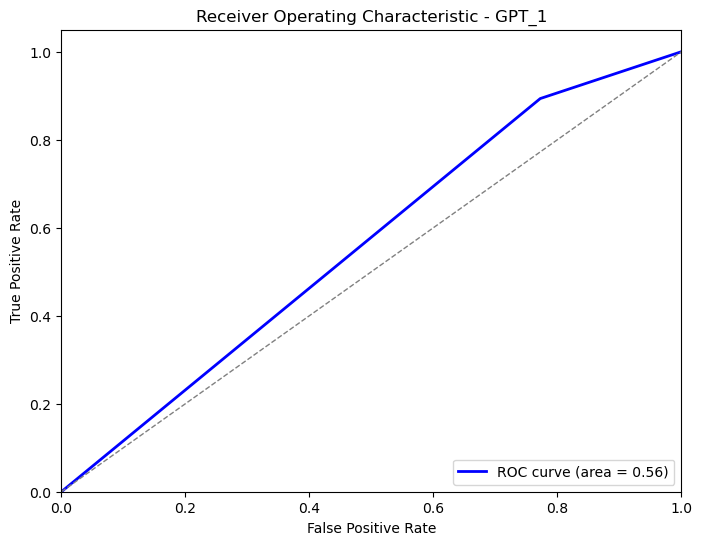

Confusion Matrix:
[[ 28  95]
 [ 48 403]]
True Positives (TP): 403
True Negatives (TN): 28
False Positives (FP): 95
False Negatives (FN): 48
Length of flattened results:  497
[True, True, True, True, True]
Accuracy (prompt GPT_2): 0.9114688128772636
Precision (prompt GPT_2): 0.9114688128772636
Recall (prompt GPT_2): 0.9188640973630832
F1 Score (prompt GPT_2): 0.915151515151515



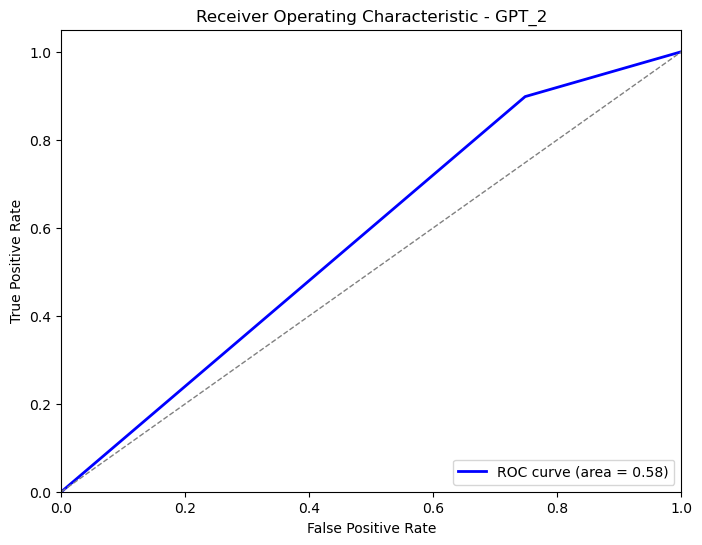

Confusion Matrix:
[[ 31  92]
 [ 46 405]]
True Positives (TP): 405
True Negatives (TN): 31
False Positives (FP): 92
False Negatives (FN): 46
Length of flattened results:  505
[False, True, True, True, True]
Accuracy (prompt GPT_3): 0.9108910891089109
Precision (prompt GPT_3): 0.9108910891089109
Recall (prompt GPT_3): 0.9330628803245437
F1 Score (prompt GPT_3): 0.9218436873747495



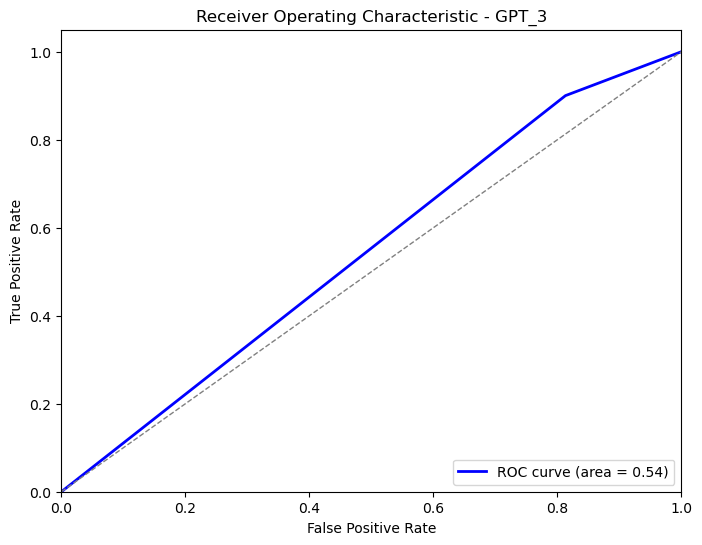

Confusion Matrix:
[[ 23 100]
 [ 45 406]]
True Positives (TP): 406
True Negatives (TN): 23
False Positives (FP): 100
False Negatives (FN): 45
Length of flattened results:  506
[True, True, False, True, True]
Accuracy (prompt GPT_Majority): 0.9110671936758893
Precision (prompt GPT_Majority): 0.9110671936758893
Recall (prompt GPT_Majority): 0.9350912778904665
F1 Score (prompt GPT_Majority): 0.922922922922923



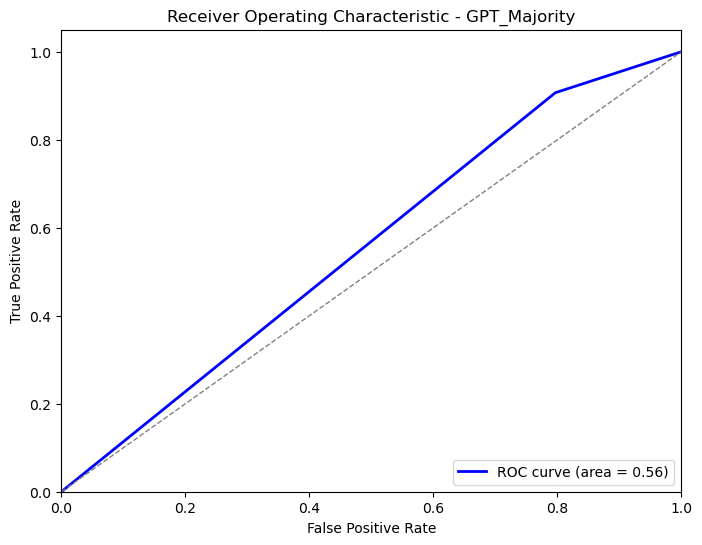

Confusion Matrix:
[[ 25  98]
 [ 42 409]]
True Positives (TP): 409
True Negatives (TN): 25
False Positives (FP): 98
False Negatives (FN): 42


In [834]:
for gpt_name in gpt_names:
    df_pred = metrics_dataframe(sentences_list, extract_metaphors(df_labels, name=gpt_name))
    calculate_metrics(df_labels, gpt_name, Fuzzy=True)
    plot_roc_auc(df_true, df_pred, model_name=gpt_name)
    

# Chat GPT Labels for entire dataset EDA:

In [915]:
# Load the GPT-4 output from the pickle file
with open('gpt_answer_all.pkl', 'rb') as f:
    gpt_answer_all = pickle.load(f)

print("Lenght of GPT-4 output for the first prompt: ", len(gpt_answer_all))

gpt_answer_all_1 = gpt_answer_all[1:]


Lenght of GPT-4 output for the first prompt:  406


In [916]:
print("Shape of the dataset before adding GPT-4 output: ", df.shape)

df = add_columns_to_dataframe(df, gpt_answer_all, name="TEST")

print("Shape of the dataset after adding GPT-4 output: ", df.shape)

df.head()

Shape of the dataset before adding GPT-4 output:  (519, 32)
Shape of the dataset after adding GPT-4 output:  (519, 32)


,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,Frequency,Sentences_len,Sentence_GPT_1,Category_GPT_1,Sentence_GPT_2,Category_GPT_2,Sentence_GPT_3,Category_GPT_3,Sentence_TEST,Category_TEST
0,0,2005-12-23,Interview with Der Spiegel,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"SPIEGEL: Monsieur Trichet, any concrete uttera...",The publication of the translation was authori...,NaN,NaN,...,5,3,[can you say that you accomplished your missio...,"[warfare, warfare, sports]",[since the inception of the single currency we...,"[warfare, sports]",[can you say that you accomplished your missio...,"[warfare, warfare, sports]",[china worries that such rapid growth could ig...,"[fire, animal]"
1,1,2005-12-19,Interview with Hospodářské Noviny,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The new EU member states want to adopt the eur...,These questions are all closely related to eac...,NaN,NaN,...,1,1,[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]",[we will in the future take the decisions that...,"[machine, disease, plant]"
2,2,2005-12-19,Interview with Financial Times and Financial T...,Lucas Papademos,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"Mr Papademos, you have responsibility as ECB V...",A comparison of the risks involved when short-...,NaN,NaN,...,18,11,[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]",[we are not confronted with deflation but with...,[warfare]
3,3,2005-12-15,Interview with Paris Match,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Paris Match. After two uneventful years at the...,The publication of the translation was authori...,NaN,NaN,...,7,5,[we consider that such anchoring has been a ve...,"[warfare, sports, sports, warfare]",[we consider that such anchoring has been a ve...,"[warfare, sports, sports, orientation]",[what i would say is that in our case it is ve...,"[orientation, orientation, sports, sports, ori...",[if longterm interest rates remain at a low le...,"[orientation, orientation, plant, orientation,..."
4,4,2005-12-09,Interview in Il Giornale,Lorenzo Bini Smaghi,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"However, Europe’s politicians, with few except...","By Angelo Allegri, our correspondent in Frankf...",NaN,NaN,...,7,7,[monthly headline inflation can be low provide...,"[disease, orientation, orientation, orientatio...",[monthly headline inflation can be low provide...,"[disease, orientation, orientation]",[monthly headline inflation can be low provide...,"[disease, orientation, orientation, orientatio...",[you are exaggerating the increase in the cost...,"[plant, disease, other, disease, machine]"


In [917]:
# Sanity check:
print("Total number of Sentences (with words_to_match): ", df['Sentences'].apply(len).sum())
print("")
print("Total number of sentences in the 'Sentence_GPT_1' column: ", df['Sentence_TEST'].apply(len).sum())
print("")
print("Ratio of GPT (Prompt 1) Metaphors to Sentences: ", df['Sentence_TEST'].apply(len).sum() / df['Sentences'].apply(len).sum())

Total number of Sentences (with words_to_match):  3422

Total number of sentences in the 'Sentence_GPT_1' column:  2691

Ratio of GPT (Prompt 1) Metaphors to Sentences:  0.7863822326125073


In [902]:
# Load the GPT-4 output from the pickle file
with open('gpt_answer_all_1.pkl', 'rb') as f:
    gpt_answer_all_1 = pickle.load(f)

with open('gpt_answer_all_2.pkl', 'rb') as f:
    gpt_answer_all_2 = pickle.load(f)

with open('gpt_answer_all_3.pkl', 'rb') as f:
    gpt_answer_all_3 = pickle.load(f)

print("Lenght of GPT-4 output for the first prompt: ", len(gpt_answer_all_1))
print("Lenght of GPT-4 output for the second prompt: ", len(gpt_answer_all_2))
print("Lenght of GPT-4 output for the third prompt: ", len(gpt_answer_all_3))

Lenght of GPT-4 output for the first prompt:  406
Lenght of GPT-4 output for the second prompt:  406
Lenght of GPT-4 output for the third prompt:  406


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


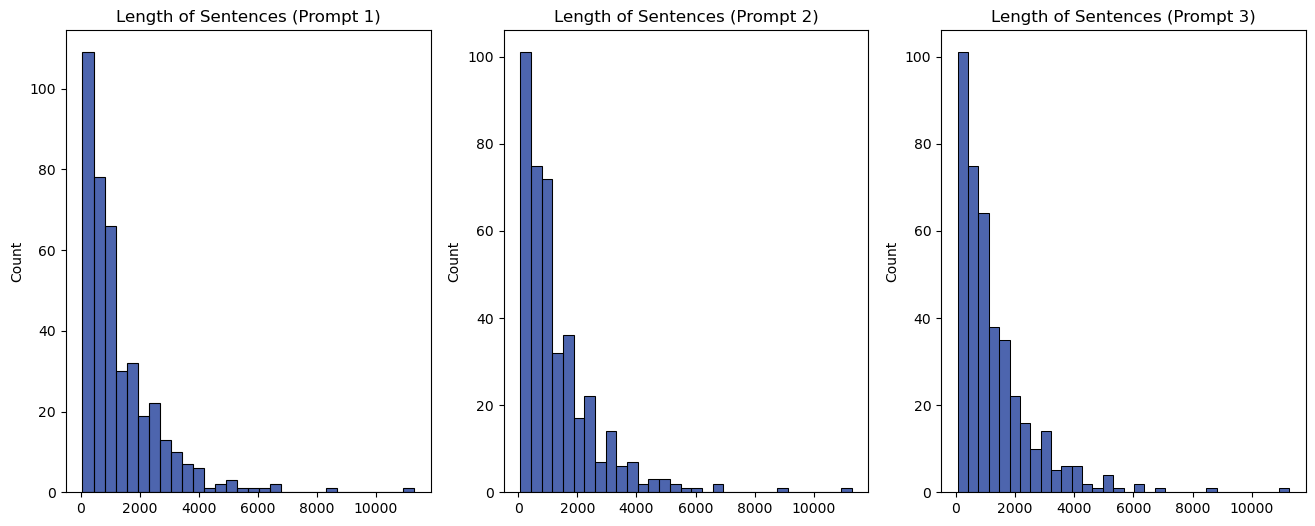

In [909]:
# Print distribution of the length of the sentences
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.histplot([len(sentences) for sentences in gpt_answer_all_1], ax=ax[0], color=color)
ax[0].set_title("Length of Sentences (Prompt 1)")
sns.histplot([len(sentences) for sentences in gpt_answer_all_2], ax=ax[1], color=color)
ax[1].set_title("Length of Sentences (Prompt 2)")
sns.histplot([len(sentences) for sentences in gpt_answer_all_3], ax=ax[2], color=color)
ax[2].set_title("Length of Sentences (Prompt 3)")
plt.show()

In [903]:
# Drop the first element which is the initial prompt
gpt_answer_all_1 = gpt_answer_all_1[1:]
gpt_answer_all_2 = gpt_answer_all_2[1:]
gpt_answer_all_3 = gpt_answer_all_3[1:]

print("Shape of the dataset before adding GPT-4 output: ", df.shape)

for gpt_name, gpt_answer in zip(gpt_names, [gpt_answer_1, gpt_answer_2, gpt_answer_3]):
    df = add_columns_to_dataframe(df, gpt_answer, name=gpt_name)

print("Shape of the dataset after adding GPT-4 output: ", df.shape)

df.head()

Shape of the dataset before adding GPT-4 output:  (519, 24)
Shape of the dataset after adding GPT-4 output:  (519, 30)


,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT_1,Category_GPT_1,Sentence_GPT_2,Category_GPT_2,Sentence_GPT_3,Category_GPT_3
0,0,2005-12-23,Interview with Der Spiegel,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"SPIEGEL: Monsieur Trichet, any concrete uttera...",The publication of the translation was authori...,NaN,NaN,...,0,[We will in the future take the decisions that...,5,3,[can you say that you accomplished your missio...,"[warfare, warfare, sports]",[since the inception of the single currency we...,"[warfare, sports]",[can you say that you accomplished your missio...,"[warfare, warfare, sports]"
1,1,2005-12-19,Interview with Hospodářské Noviny,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The new EU member states want to adopt the eur...,These questions are all closely related to eac...,NaN,NaN,...,0,[We are not confronted with deflation but with...,1,1,[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]",[as regards inflation i understand the deepsea...,"[disease, orientation]"
2,2,2005-12-19,Interview with Financial Times and Financial T...,Lucas Papademos,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"Mr Papademos, you have responsibility as ECB V...",A comparison of the risks involved when short-...,NaN,NaN,...,2,[If longterm interest rates remain at a low le...,18,11,[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]",[on the other hand in july there were upside r...,"[orientation, disease]"
3,3,2005-12-15,Interview with Paris Match,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Paris Match. After two uneventful years at the...,The publication of the translation was authori...,NaN,NaN,...,0,[You are exaggerating the increase in the cost...,7,5,[we consider that such anchoring has been a ve...,"[warfare, sports, sports, warfare]",[we consider that such anchoring has been a ve...,"[warfare, sports, sports, orientation]",[what i would say is that in our case it is ve...,"[orientation, orientation, sports, sports, ori..."
4,4,2005-12-09,Interview in Il Giornale,Lorenzo Bini Smaghi,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"However, Europe’s politicians, with few except...","By Angelo Allegri, our correspondent in Frankf...",NaN,NaN,...,0,[The rise has helped to keep inflation expecta...,7,7,[monthly headline inflation can be low provide...,"[disease, orientation, orientation, orientatio...",[monthly headline inflation can be low provide...,"[disease, orientation, orientation]",[monthly headline inflation can be low provide...,"[disease, orientation, orientation, orientatio..."


In [907]:
# Sanity check:
print("Total number of Sentences (with words_to_match): ", df['Sentences'].apply(len).sum())
print("")
print("Total number of sentences in the 'Sentence_GPT_1' column: ", df['Sentence_GPT_1'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT_2' column: ", df['Sentence_GPT_2'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT_3' column: ", df['Sentence_GPT_3'].apply(len).sum())
print("")
print("Ratio of GPT (Prompt 1) Metaphors to Sentences: ", df['Sentence_GPT_1'].apply(len).sum() / df['Sentences'].apply(len).sum())
print("Ratio of GPT (Prompt 2) Metaphors to Sentences: ", df['Sentence_GPT_2'].apply(len).sum() / df['Sentences'].apply(len).sum())
print("Ratio of GPT (Prompt 3) Metaphors to Sentences: ", df['Sentence_GPT_3'].apply(len).sum() / df['Sentences'].apply(len).sum())

Total number of Sentences (with words_to_match):  3422

Total number of sentences in the 'Sentence_GPT_1' column:  497
Total number of sentences in the 'Sentence_GPT_2' column:  497
Total number of sentences in the 'Sentence_GPT_3' column:  505

Ratio of GPT (Prompt 1) Metaphors to Sentences:  0.14523670368205727
Ratio of GPT (Prompt 2) Metaphors to Sentences:  0.14523670368205727
Ratio of GPT (Prompt 3) Metaphors to Sentences:  0.14757451782583283


# Majority Voting:

In [84]:
# Sanity check:
print("Total number of sentences in the 'Sentences' column: ", df['Sentences'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT' column: ", df['Sentence_GPT'].apply(len).sum())
print("Total number of sentences in the 'Category_GPT' column: ", df['Category_GPT'].apply(len).sum())

print("Ratio of (GPT) Metaphors to Sentences: ", df['Sentence_GPT'].apply(len).sum() / df['Sentences'].apply(len).sum())

Total number of sentences in the 'Sentences' column:  3422
Total number of sentences in the 'Sentence_GPT' column:  2702
Total number of sentences in the 'Category_GPT' column:  2702
Ratio of (GPT) Metaphors to Sentences:  0.7895967270601987


In [85]:
df = add_comparison_column_GPT(df)
df.head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,list_regex_reduced_len,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT,Category_GPT,Matched_Metaphors
0,0,2005-12-23,Interview with Der Spiegel,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"SPIEGEL: Monsieur Trichet, any concrete uttera...",The publication of the translation was authori...,NaN,NaN,...,3,9371,[],0,[We will in the future take the decisions that...,5,3,[we will in the future take the decisions that...,"[machine, disease, plant]","[True, True, True]"
1,1,2005-12-19,Interview with Hospodářské Noviny,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The new EU member states want to adopt the eur...,These questions are all closely related to eac...,NaN,NaN,...,1,3209,[],0,[We are not confronted with deflation but with...,1,1,[we are not confronted with deflation but with...,[warfare],[True]
2,2,2005-12-19,Interview with Financial Times and Financial T...,Lucas Papademos,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"Mr Papademos, you have responsibility as ECB V...",A comparison of the risks involved when short-...,NaN,NaN,...,10,16231,"[('low', 'inflation'), ('current', 'inflation')]",2,[If longterm interest rates remain at a low le...,18,11,[if longterm interest rates remain at a low le...,"[orientation, orientation, plant, orientation,...","[True, True, True, True, True, True, True, Tru..."
3,3,2005-12-15,Interview with Paris Match,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Paris Match. After two uneventful years at the...,The publication of the translation was authori...,NaN,NaN,...,4,8186,[],0,[You are exaggerating the increase in the cost...,7,5,[you are exaggerating the increase in the cost...,"[plant, disease, other, disease, machine]","[True, True, True, True, True]"
4,4,2005-12-09,Interview in Il Giornale,Lorenzo Bini Smaghi,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"However, Europe’s politicians, with few except...","By Angelo Allegri, our correspondent in Frankf...",NaN,NaN,...,7,6765,[],0,[The rise has helped to keep inflation expecta...,7,7,[the rise has helped to keep inflation expecta...,"[orientation, orientation, orientation, orient...","[True, True, True, True, True, True, True]"


In [86]:
print("Total number of Comparison made: ", df['Matched_Metaphors'].apply(len).sum())

# Print the number of True values in the 'Comparison_Result' column
print("Total number of True values in the 'Comparison_Result' column: ", df['Matched_Metaphors'].apply(sum).sum())

# print ratio of True values to the total number of comparisons made 
print("Ratio of True values to the total number of comparisons made: ", df['Matched_Metaphors'].apply(sum).sum() / df['Matched_Metaphors'].apply(len).sum())

Total number of Comparison made:  2702
Total number of True values in the 'Comparison_Result' column:  2592
Ratio of True values to the total number of comparisons made:  0.9592894152479645


In [1395]:
"""# Save the final dataset to a CSV file
df.to_csv('Final_Working_Data_with_GPT_Output.csv', index=False)"""

"# Save the final dataset to a CSV file\ndf.to_csv('Final_Working_Data_with_GPT_Output.csv', index=False)"